In [1]:
import pandas as pd
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import urbanFormPy as up

In [5]:
city_name = 'London'
epsg = 27700
crs = {'init': 'epsg:27700', 'no_defs': True}

### Download secondary network (or pedestrian network) from OSM

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [ ]:
place = 'Greater London'
download_method = 'OSMplace'
distance = None

nodes_graph_ped, edges_graph_ped = up.get_network_fromOSM(place, download_method, 'drive', epsg, distance = distance)
nodes_graph_ped, edges_graph_ped = up.clean_network(nodes_graph_ped, edges_graph_ped, dead_ends = True, 
                                remove_disconnected_islands = True, self_loops = True, same_uv_edges = True)

### Load secondary network (or pedestrian network) from local path

In [6]:
loading_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/largeNetwork/'
nodes_graph_ped = gpd.read_file(loading_path+city_name+'_nodes_simplified.shp')
edges_graph_ped = gpd.read_file(loading_path+city_name+'_edges_simplified.shp')

try:
    nodes_graph_ped, edges_graph_ped = nodes_graph_ped.to_crs(epsg=epsg), edges_graph_ped.to_crs(epsg=epsg)
except:
    nodes_graph_ped.crs, edges_graph_ped.crs = crs, crs

nodes_graph_ped.index, edges_graph_ped.index  = nodes_graph_ped.nodeID, edges_graph_ped.edgeID
nodes_graph_ped.index.name, edges_graph_ped.index.name  = None, None

### Load drivable/simplified network from local path - the one where edges are assigned to districts 

In [7]:
# network with districts already assigned
loading_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/entireNetwork/'
edges_graph = gpd.read_file(loading_path+city_name+'_districts.shp')

try:
    edges_graph = edges_graph.to_crs(epsg=epsg)
    nodes_graph_ped, edges_graph_ped = nodes_graph_ped.to_crs(epsg=epsg), edges_graph_ped.to_crs(epsg=epsg)
except:
    edges_graph.crs = crs
    nodes_graph_ped.crs, edges_graph_ped.crs = crs, crs

edges_graph.index = edges_graph.edgeID
edges_graph.index.name  = None, None
nodes_graph_ped.index, edges_graph_ped.index  = nodes_graph_ped.nodeID, edges_graph_ped.edgeID
nodes_graph_ped.index.name, edges_graph_ped.index.name  = None, None

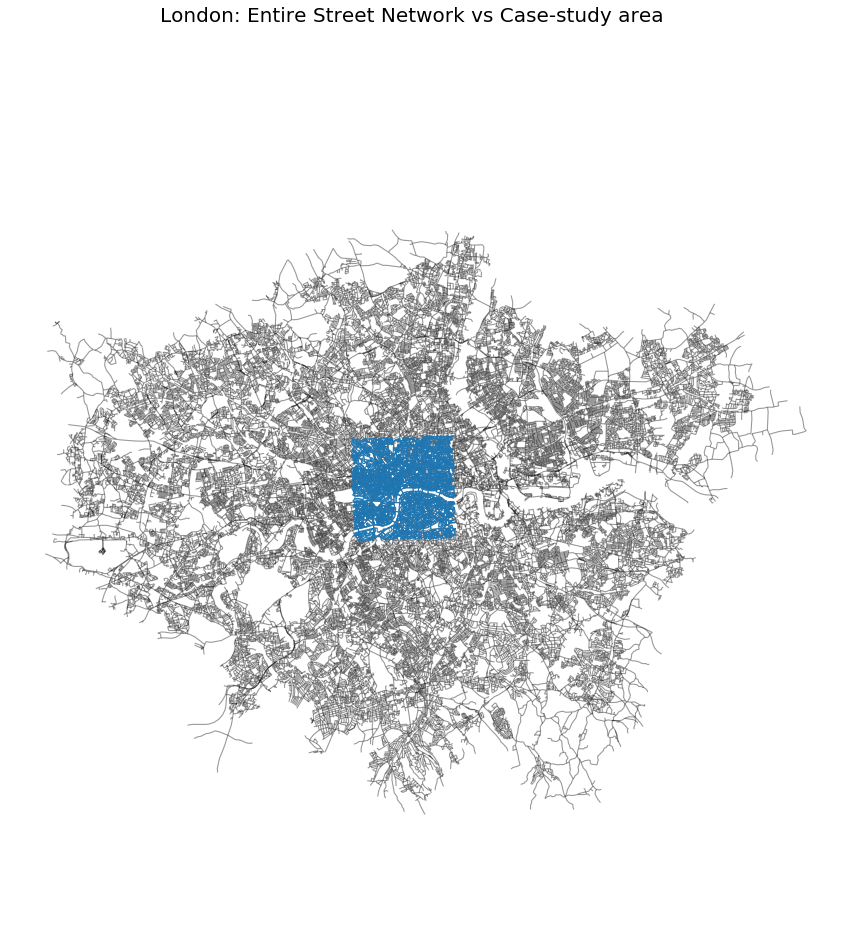

In [10]:
up.plot_lines(edges_graph_ped, scheme = None,  black_background = False, fig_size = 15, title = 
              city_name+': Entire Street Network vs Case-study area',
             gdf_base_map = edges_graph, base_map_color = 'black', base_map_alpha = 0.3,)

### Visualisation districts extracted from dual graph of the entire network (assigned to the corresponding primal edges)

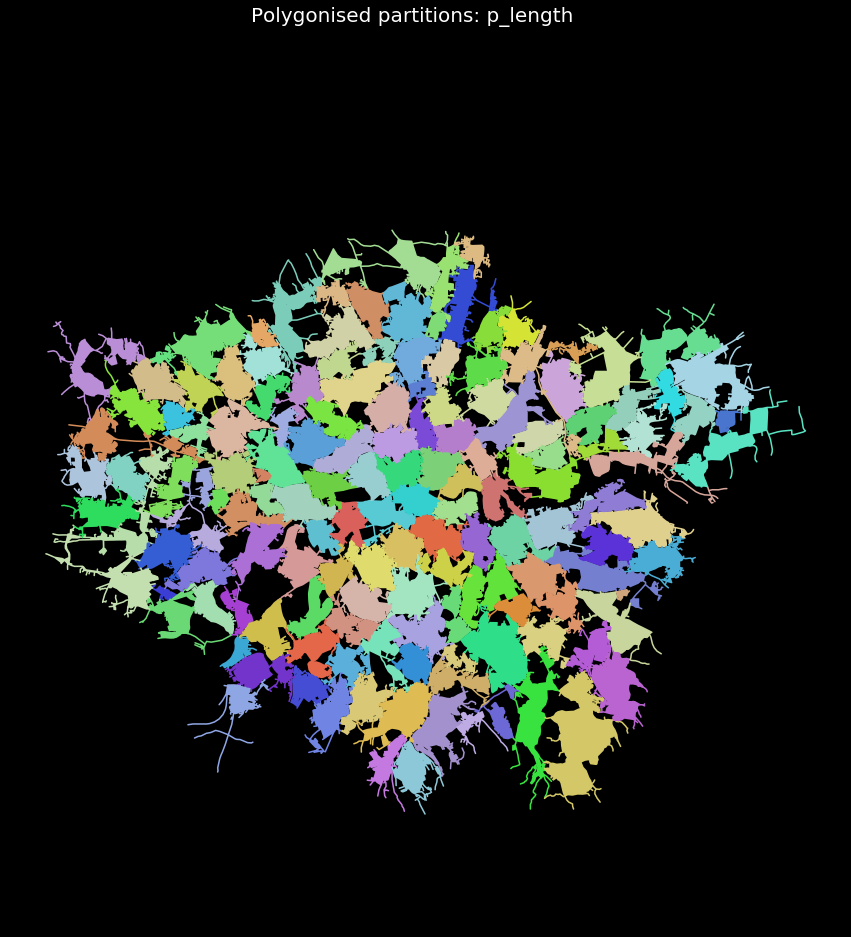

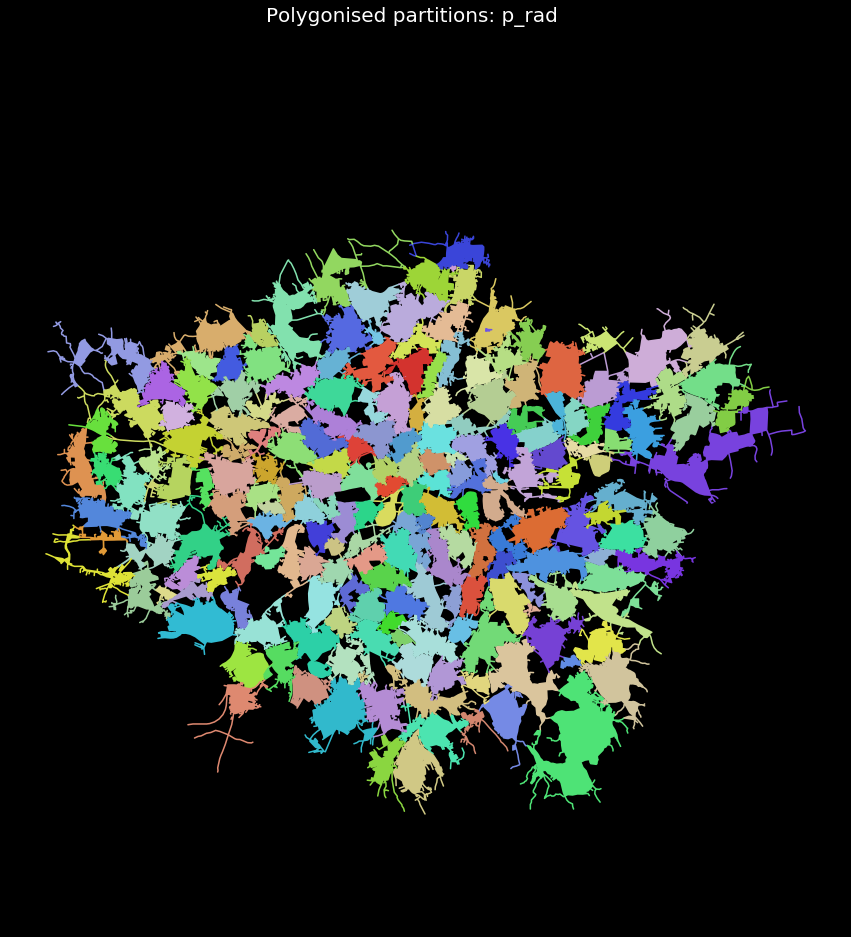

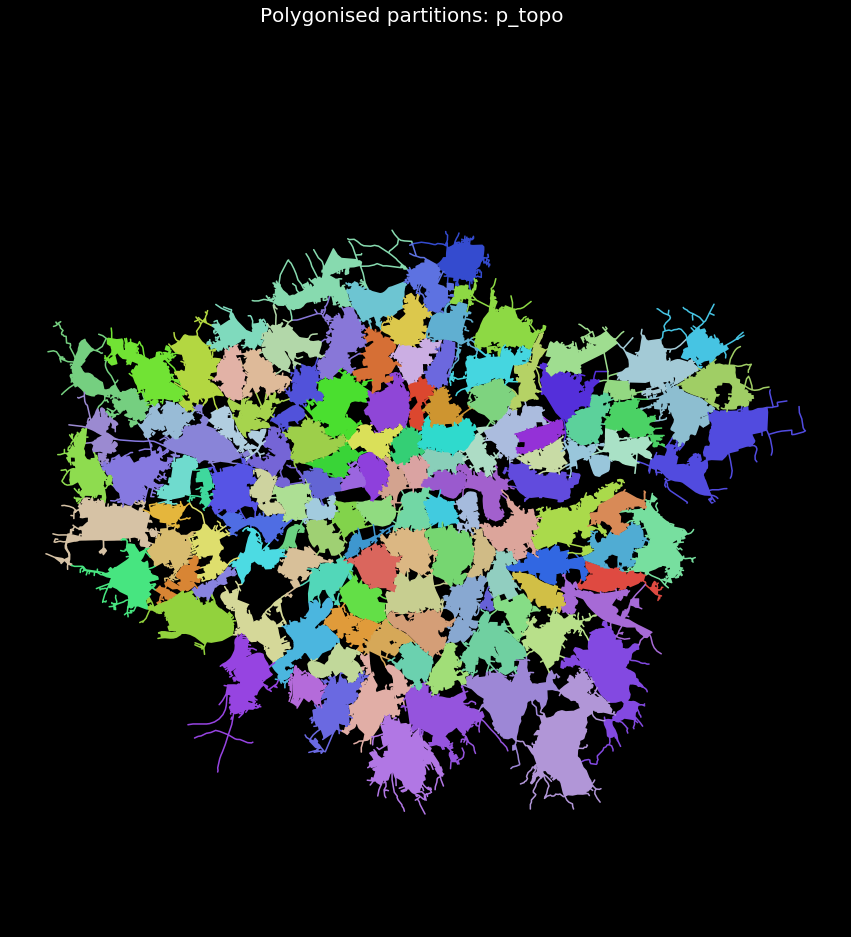

In [11]:
columns = ['p_length','p_rad', 'p_topo']

for column in columns:
    cmap = up.rand_cmap(nlabels = len(edges_graph[column].unique()), type_color='bright', first_color_black=False, 
                     last_color_black=False)
    dc = dict(edges_graph[column].value_counts())
    to_ignore = {k: v for k, v in dc.items() if v <= 3}
    tmp = edges_graph[~edges_graph[column].isin(to_ignore)].copy()
    partitions = up.polygonise_partition(tmp, column, crs)
    up.plot_polygons(partitions, column = 'partitionID', cmap = cmap, title =  "Polygonised partitions: "+ column, 
                     black_background = True,  fig_size = 15)

## Assign nodes and edges in the pedestrian network to a partition

In [12]:
# choose column
column = 'p_rad'

dc = dict(edges_graph[column].value_counts())
to_ignore = {k: v for k, v in dc.items() if v <= 10}
tmp = edges_graph[~((edges_graph[column].isin(to_ignore))| (edges_graph['p_rad'] == 999999))].copy()
partitions = up.polygonise_partition(tmp, column)
nodes_graph_ped['district'] = nodes_graph_ped.apply(lambda row: 
                                            up.district_to_nodes_from_polygons(row['geometry'], partitions), axis = 1)
nodes_graph_ped['district'] = nodes_graph_ped.district.astype(int)

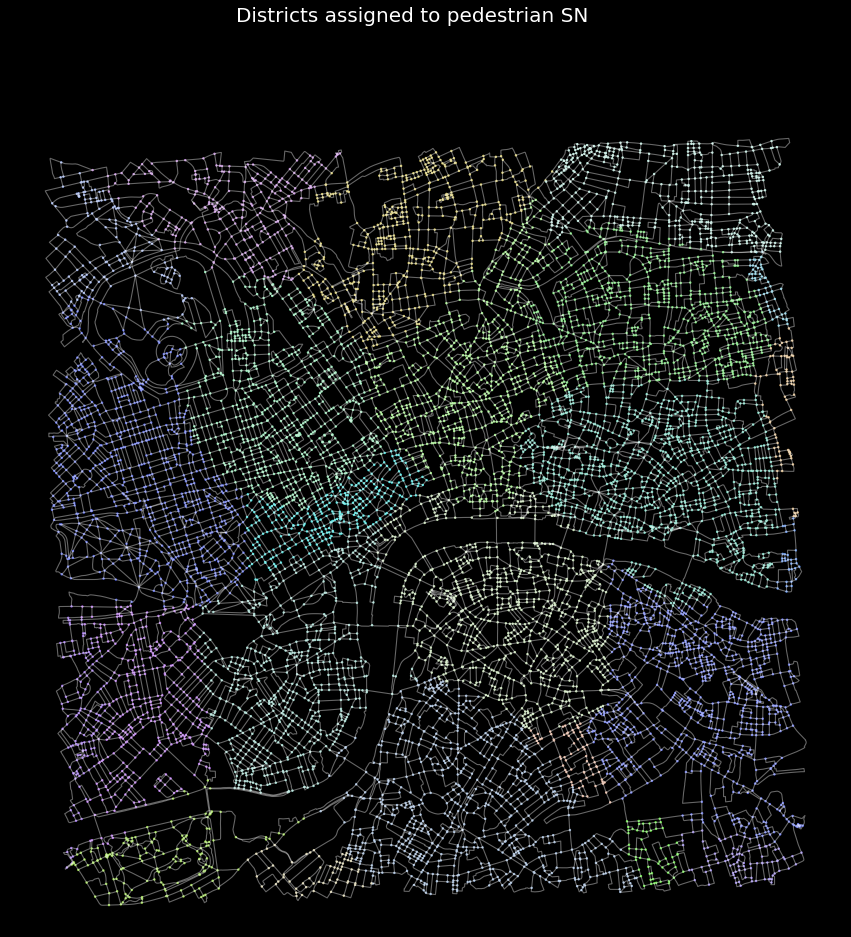

In [13]:
# visualisation
cmap = up.rand_cmap(nlabels = len(nodes_graph_ped['district'].unique()), type_color='bright', first_color_black=False, 
                 last_color_black=False)
up.plot_points(nodes_graph_ped, column = 'district', title = 'Districts assigned to pedestrian SN', cmap = cmap, ms = 3.5,
              gdf_base_map = edges_graph_ped, base_map_color = 'white', base_map_alpha = 0.35,
               black_background = True, legend = False, fig_size = 15)

In [14]:
# fixing disconnected districts and assigning nodes to existing connected districts
nodes_graph_ped = up.check_disconnected_regions(nodes_graph_ped, edges_graph_ped)

while (999999 in nodes_graph_ped['district'].unique()):
    nodes_graph_ped['district'] = nodes_graph_ped.apply(lambda row: up.amend_node_membership(row['nodeID'], nodes_graph_ped,
                                edges_graph_ped), axis = 1)
    nodes_graph_ped = up.check_disconnected_regions(nodes_graph_ped, edges_graph_ped)
    
# assign gateways
nodes_graph_ped['gateway'] = nodes_graph_ped.apply(lambda row: up.find_gateways(row['nodeID'], nodes_graph_ped, 
                                                                             edges_graph_ped,), axis = 1)

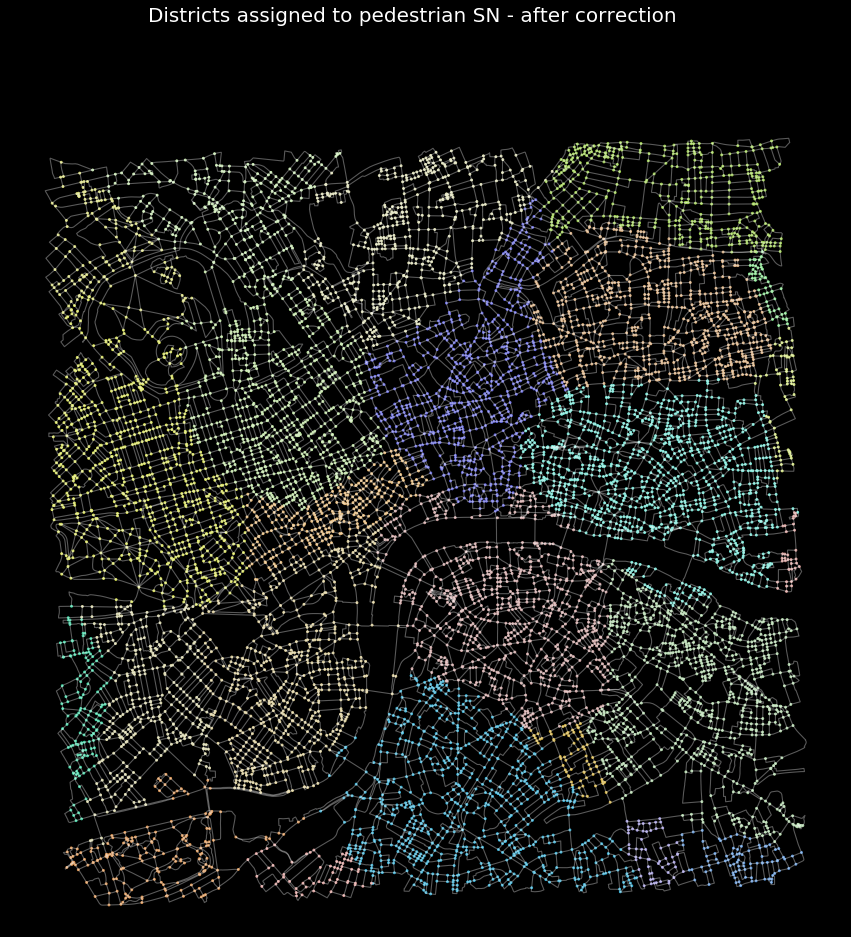

In [16]:
# visualisation
cmap = up.rand_cmap(nlabels = len(nodes_graph_ped['district'].unique()), type_color='bright', first_color_black=False, 
                 last_color_black=False)
up.plot_points(nodes_graph_ped, column = 'district', title = 'Districts assigned to pedestrian SN - after correction', 
               cmap = cmap, ms = 3.5, gdf_base_map = edges_graph_ped, base_map_color = 'white', base_map_alpha = 0.35,
               black_background = True, legend = False, fig_size = 15)

### Save

In [17]:
saving_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/largeNetwork/'
nodes_graph_ped.to_file(saving_path+city_name+'_nodes_simplified.shp', driver='ESRI Shapefile')
edges_graph_ped.to_file(saving_path+city_name+"_edges_simplified.shp", driver='ESRI Shapefile')